<a href="https://colab.research.google.com/github/s34836/EWD/blob/main/lab12.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Lab - Trees

## Tasks

1. Load the `Carseats.csv` dataset. Drop the `Sales` column and replace it with a categorical column `SalesHigh`, which should take the value `Yes` if `Sales >= 8` and `No` otherwise. Use decision trees to predict the value of `SalesHigh` based on the other variables.
    - Divide the data into training, validation and test sets (or use cross validation instead of validation set).
    - Fit a [`DecisionTreeClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html) model.
    - Apply pruning to reduce the size of the tree. Generate `ccp_alpha` values with the `cost_complexity_pruning_path()` method. Find the best `ccp_alpha` using the validation set or cross validation (e.g. [`GridSearchCV`](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html)).
    - Compare the pruned and unpruned trees. How did pruning affect the quality of predictions? How did it affect the size of the model (compare tree sizes using the methods `get_depth()` and `get_n_leaves()`).
    - Fit a [`RandomForestClassifier`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html) and compare it to single-tree models.
    - Select the best decision tree, taking into account both prediction accuracy and model size. Visualize the tree using the method [`plot_tree()`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.plot_tree.html). Use the test set to evaluate the model.


In [16]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn.ensemble import RandomForestClassifier
import matplotlib.pyplot as plt
from sklearn.tree import plot_tree
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns


#Load the Carseats.csv dataset. Drop the Sales column and replace it
#with a categorical column SalesHigh, which should take the value Yes if Sales >= 8 and No otherwise.

df = pd.read_csv('Carseats.csv')
df['SalesHigh'] = ['Yes' if x >= 8 else 'No' for x in df['Sales']]
df = df.drop('Sales', axis=1)

print(df.head())

   CompPrice  Income  Advertising  Population  Price ShelveLoc  Age  \
0        138      73           11         276    120       Bad   42   
1        111      48           16         260     83      Good   65   
2        113      35           10         269     80    Medium   59   
3        117     100            4         466     97    Medium   55   
4        141      64            3         340    128       Bad   38   

   Education Urban   US SalesHigh  
0         17   Yes  Yes       Yes  
1         10   Yes  Yes       Yes  
2         12   Yes  Yes       Yes  
3         14   Yes  Yes        No  
4         13   Yes   No        No  


In [17]:
#Divide the data into training, validation and test sets
#(or use cross validation instead of validation set).

train_val_data, test_data = train_test_split(df, test_size=0.2, random_state=1)
train_data, val_data = train_test_split(train_val_data, test_size=0.25, random_state=1)

print(f"Full dataset shape: {df.shape}")
print(f"Training set shape: {train_data.shape}")
print(f"Validation set shape: {val_data.shape}")
print(f"Test set shape: {test_data.shape}")


Full dataset shape: (400, 11)
Training set shape: (240, 11)
Validation set shape: (80, 11)
Test set shape: (80, 11)


In [18]:
#Fit a DecisionTreeClassifier model.
X_train = train_data.drop('SalesHigh', axis=1)
y_train = train_data['SalesHigh']

X_train = pd.get_dummies(X_train, drop_first=True)
unpruned_tree = DecisionTreeClassifier(random_state=1)
unpruned_tree.fit(X_train, y_train)

# Print model information
print("Decision Tree model has been fitted.")
print(f"Number of nodes: {unpruned_tree.tree_.node_count}")
print(f"Depth of tree: {unpruned_tree.get_depth()}")

Decision Tree model has been fitted.
Number of nodes: 81
Depth of tree: 10


In [20]:
#Apply pruning to reduce the size of the tree. Generate ccp_alpha values with
#the cost_complexity_pruning_path() method. Find the best ccp_alpha using the
#validation set or cross validation (e.g. GridSearchCV).

# Prepare validation data
X_val = val_data.drop('SalesHigh', axis=1)
y_val = val_data['SalesHigh']
X_val = pd.get_dummies(X_val, drop_first=True)

# Get the cost complexity pruning path
path = unpruned_tree.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas

# Remove the last alpha which is the largest and would give a trivial tree
ccp_alphas = ccp_alphas[:-1]

# Create trees with different alphas and evaluate on validation set
acc_scores = []
trees = []

for ccp_alpha in ccp_alphas:
    dt = DecisionTreeClassifier(random_state=42, ccp_alpha=ccp_alpha)
    dt.fit(X_train, y_train)
    y_val_pred = dt.predict(X_val)
    acc = accuracy_score(y_val, y_val_pred)
    acc_scores.append(acc)
    trees.append(dt)

# Find the best alpha
best_alpha_idx = np.argmax(acc_scores)
best_alpha = ccp_alphas[best_alpha_idx]
pruned_tree = trees[best_alpha_idx]

print(f"Best ccp_alpha: {best_alpha}")
print(f"Validation accuracy with best alpha: {acc_scores[best_alpha_idx]}")
print(f"Original tree nodes: {unpruned_tree.tree_.node_count}, depth: {unpruned_tree.get_depth()}")
print(f"Pruned tree nodes: {pruned_tree.tree_.node_count}, depth: {pruned_tree.get_depth()}")


Best ccp_alpha: 0.005263157894736845
Validation accuracy with best alpha: 0.8
Original tree nodes: 81, depth: 10
Pruned tree nodes: 59, depth: 10


In [21]:
# Compare pruned and unpruned trees. How did pruning affect the quality
# of predictions? How did it affect the size of the model (compare tree sizes
#using the methods get_depth() and get_n_leaves()).

# Evaluate unpruned tree on validation set
y_val_pred_unpruned = unpruned_tree.predict(X_val)
unpruned_accuracy = accuracy_score(y_val, y_val_pred_unpruned)

# Evaluate pruned tree on validation set
y_val_pred_pruned = pruned_tree.predict(X_val)
pruned_accuracy = accuracy_score(y_val, y_val_pred_pruned)

# Evaluate both models on test set
X_test = test_data.drop('SalesHigh', axis=1)
y_test = test_data['SalesHigh']
X_test = pd.get_dummies(X_test, drop_first=True)


y_test_pred_unpruned = unpruned_tree.predict(X_test)
y_test_pred_pruned = pruned_tree.predict(X_test)

unpruned_test_accuracy = accuracy_score(y_test, y_test_pred_unpruned)
pruned_test_accuracy = accuracy_score(y_test, y_test_pred_pruned)

# Compare model sizes
print("\nComparison of Tree Sizes:")
print(f"Unpruned Tree - Depth: {unpruned_tree.get_depth()}, Leaves: {unpruned_tree.get_n_leaves()}, Nodes: {unpruned_tree.tree_.node_count}")
print(f"Pruned Tree - Depth: {pruned_tree.get_depth()}, Leaves: {pruned_tree.get_n_leaves()}, Nodes: {pruned_tree.tree_.node_count}")
print(f"Reduction in Depth: {unpruned_tree.get_depth() - pruned_tree.get_depth()} ({(1 - pruned_tree.get_depth()/unpruned_tree.get_depth())*100:.1f}%)")
print(f"Reduction in Leaves: {unpruned_tree.get_n_leaves() - pruned_tree.get_n_leaves()} ({(1 - pruned_tree.get_n_leaves()/unpruned_tree.get_n_leaves())*100:.1f}%)")
print(f"Reduction in Nodes: {pruned_tree.tree_.node_count - pruned_tree.tree_.node_count} ({(1 - pruned_tree.tree_.node_count/unpruned_tree.tree_.node_count)*100:.1f}%)")

print("\nComparison of Prediction Quality:")
print(f"Validation Set - Unpruned Accuracy: {unpruned_accuracy:.4f}, Pruned Accuracy: {pruned_accuracy:.4f}")
print(f"Test Set - Unpruned Accuracy: {unpruned_test_accuracy:.4f}, Pruned Accuracy: {pruned_test_accuracy:.4f}")

# Calculate if pruning helped with overfitting by comparing train-test accuracy differences
X_train_eval = X_train
y_train_pred_unpruned = unpruned_tree.predict(X_train_eval)
y_train_pred_pruned = pruned_tree.predict(X_train_eval)
unpruned_train_accuracy = accuracy_score(y_train, y_train_pred_unpruned)
pruned_train_accuracy = accuracy_score(y_train, y_train_pred_pruned)

unpruned_overfit = unpruned_train_accuracy - unpruned_test_accuracy
pruned_overfit = pruned_train_accuracy - pruned_test_accuracy

print("\nOverfitting Analysis:")
print(f"Unpruned Tree - Train Accuracy: {unpruned_train_accuracy:.4f}, Test Accuracy: {unpruned_test_accuracy:.4f}, Difference: {unpruned_overfit:.4f}")
print(f"Pruned Tree - Train Accuracy: {pruned_train_accuracy:.4f}, Test Accuracy: {pruned_test_accuracy:.4f}, Difference: {pruned_overfit:.4f}")
if unpruned_overfit > pruned_overfit:
    print("The pruned tree shows less overfitting compared to the unpruned tree.")
else:
    print("The pruned tree does not show reduced overfitting compared to the unpruned tree.")


Comparison of Tree Sizes:
Unpruned Tree - Depth: 10, Leaves: 41, Nodes: 81
Pruned Tree - Depth: 10, Leaves: 30, Nodes: 59
Reduction in Depth: 0 (0.0%)
Reduction in Leaves: 11 (26.8%)
Reduction in Nodes: 0 (27.2%)

Comparison of Prediction Quality:
Validation Set - Unpruned Accuracy: 0.7750, Pruned Accuracy: 0.8000
Test Set - Unpruned Accuracy: 0.7875, Pruned Accuracy: 0.8125

Overfitting Analysis:
Unpruned Tree - Train Accuracy: 1.0000, Test Accuracy: 0.7875, Difference: 0.2125
Pruned Tree - Train Accuracy: 0.9750, Test Accuracy: 0.8125, Difference: 0.1625
The pruned tree shows less overfitting compared to the unpruned tree.


In [22]:
#Fit a RandomForestClassifier and compare it to single-tree models.


# Fit a RandomForestClassifier
rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
rf_model.fit(X_train, y_train)

# Make predictions with the Random Forest
y_train_pred_rf = rf_model.predict(X_train)
y_val_pred_rf = rf_model.predict(X_val)
y_test_pred_rf = rf_model.predict(X_test)

# Calculate accuracies
rf_train_accuracy = accuracy_score(y_train, y_train_pred_rf)
rf_val_accuracy = accuracy_score(y_val, y_val_pred_rf)
rf_test_accuracy = accuracy_score(y_test, y_test_pred_rf)

# Compare all models
print("\n===== Model Comparison =====")
print("\nTraining Accuracy:")
print(f"Unpruned Decision Tree: {unpruned_train_accuracy:.4f}")
print(f"Pruned Decision Tree: {pruned_train_accuracy:.4f}")
print(f"Random Forest: {rf_train_accuracy:.4f}")

print("\nValidation Accuracy:")
print(f"Unpruned Decision Tree: {unpruned_accuracy:.4f}")
print(f"Pruned Decision Tree: {pruned_accuracy:.4f}")
print(f"Random Forest: {rf_val_accuracy:.4f}")

print("\nTest Accuracy:")
print(f"Unpruned Decision Tree: {unpruned_test_accuracy:.4f}")
print(f"Pruned Decision Tree: {pruned_test_accuracy:.4f}")
print(f"Random Forest: {rf_test_accuracy:.4f}")

# Calculate overfitting metrics (train-test accuracy difference)
rf_overfit = rf_train_accuracy - rf_test_accuracy

print("\nOverfitting (Train-Test Accuracy Difference):")
print(f"Unpruned Decision Tree: {unpruned_overfit:.4f}")
print(f"Pruned Decision Tree: {pruned_overfit:.4f}")
print(f"Random Forest: {rf_overfit:.4f}")

# Compare model complexity
single_tree_size = unpruned_tree.get_n_leaves()
pruned_tree_size = pruned_tree.get_n_leaves()
rf_size = sum(estimator.get_n_leaves() for estimator in rf_model.estimators_)

print("\nModel Size (Number of Leaves):")
print(f"Unpruned Decision Tree: {single_tree_size}")
print(f"Pruned Decision Tree: {pruned_tree_size}")
print(f"Random Forest (total across all trees): {rf_size}")

# Feature importance comparison
print("\nTop 5 Important Features:")
print("\nUnpruned Decision Tree:")
dt_importances = dict(zip(X_train.columns, unpruned_tree.feature_importances_))
sorted_dt = sorted(dt_importances.items(), key=lambda x: x[1], reverse=True)[:5]
for feature, importance in sorted_dt:
    print(f"{feature}: {importance:.4f}")

print("\nPruned Decision Tree:")
pruned_importances = dict(zip(X_train.columns, pruned_tree.feature_importances_))
sorted_pruned = sorted(pruned_importances.items(), key=lambda x: x[1], reverse=True)[:5]
for feature, importance in sorted_pruned:
    print(f"{feature}: {importance:.4f}")

print("\nRandom Forest:")
rf_importances = dict(zip(X_train.columns, rf_model.feature_importances_))
sorted_rf = sorted(rf_importances.items(), key=lambda x: x[1], reverse=True)[:5]
for feature, importance in sorted_rf:
    print(f"{feature}: {importance:.4f}")

# Summary
print("\n===== Summary =====")
best_test_acc = max(unpruned_test_accuracy, pruned_test_accuracy, rf_test_accuracy)
if best_test_acc == unpruned_test_accuracy:
    best_model = "Unpruned Decision Tree"
elif best_test_acc == pruned_test_accuracy:
    best_model = "Pruned Decision Tree"
else:
    best_model = "Random Forest"

print(f"Best performing model on test data: {best_model} with accuracy {best_test_acc:.4f}")

# Check if Random Forest improved over the decision trees
if rf_test_accuracy > max(unpruned_test_accuracy, pruned_test_accuracy):
    print("The Random Forest classifier outperformed both decision tree models.")
    improvement = rf_test_accuracy - max(unpruned_test_accuracy, pruned_test_accuracy)
    print(f"Improvement in test accuracy: {improvement:.4f} ({improvement*100:.2f}%)")
else:
    print("The Random Forest classifier did not outperform the best decision tree model.")


===== Model Comparison =====

Training Accuracy:
Unpruned Decision Tree: 1.0000
Pruned Decision Tree: 0.9750
Random Forest: 1.0000

Validation Accuracy:
Unpruned Decision Tree: 0.7750
Pruned Decision Tree: 0.8000
Random Forest: 0.8125

Test Accuracy:
Unpruned Decision Tree: 0.7875
Pruned Decision Tree: 0.8125
Random Forest: 0.8000

Overfitting (Train-Test Accuracy Difference):
Unpruned Decision Tree: 0.2125
Pruned Decision Tree: 0.1625
Random Forest: 0.2000

Model Size (Number of Leaves):
Unpruned Decision Tree: 41
Pruned Decision Tree: 30
Random Forest (total across all trees): 4285

Top 5 Important Features:

Unpruned Decision Tree:
Price: 0.2868
CompPrice: 0.1798
ShelveLoc_Good: 0.1395
Advertising: 0.1301
Age: 0.1264

Pruned Decision Tree:
Price: 0.2742
CompPrice: 0.1918
ShelveLoc_Good: 0.1543
Advertising: 0.1374
Age: 0.0943

Random Forest:
Price: 0.2090
Age: 0.1492
Advertising: 0.1217
ShelveLoc_Good: 0.1148
Income: 0.1051

===== Summary =====
Best performing model on test data: Pr


===== Best Tree Model Selection =====
Unpruned Tree - Test Accuracy: 0.7875, Size: 41 leaves, Combined Score: 0.5512
Pruned Tree - Test Accuracy: 0.8125, Size: 30 leaves, Combined Score: 0.6492

Best model: Pruned Decision Tree with combined score of 0.6492


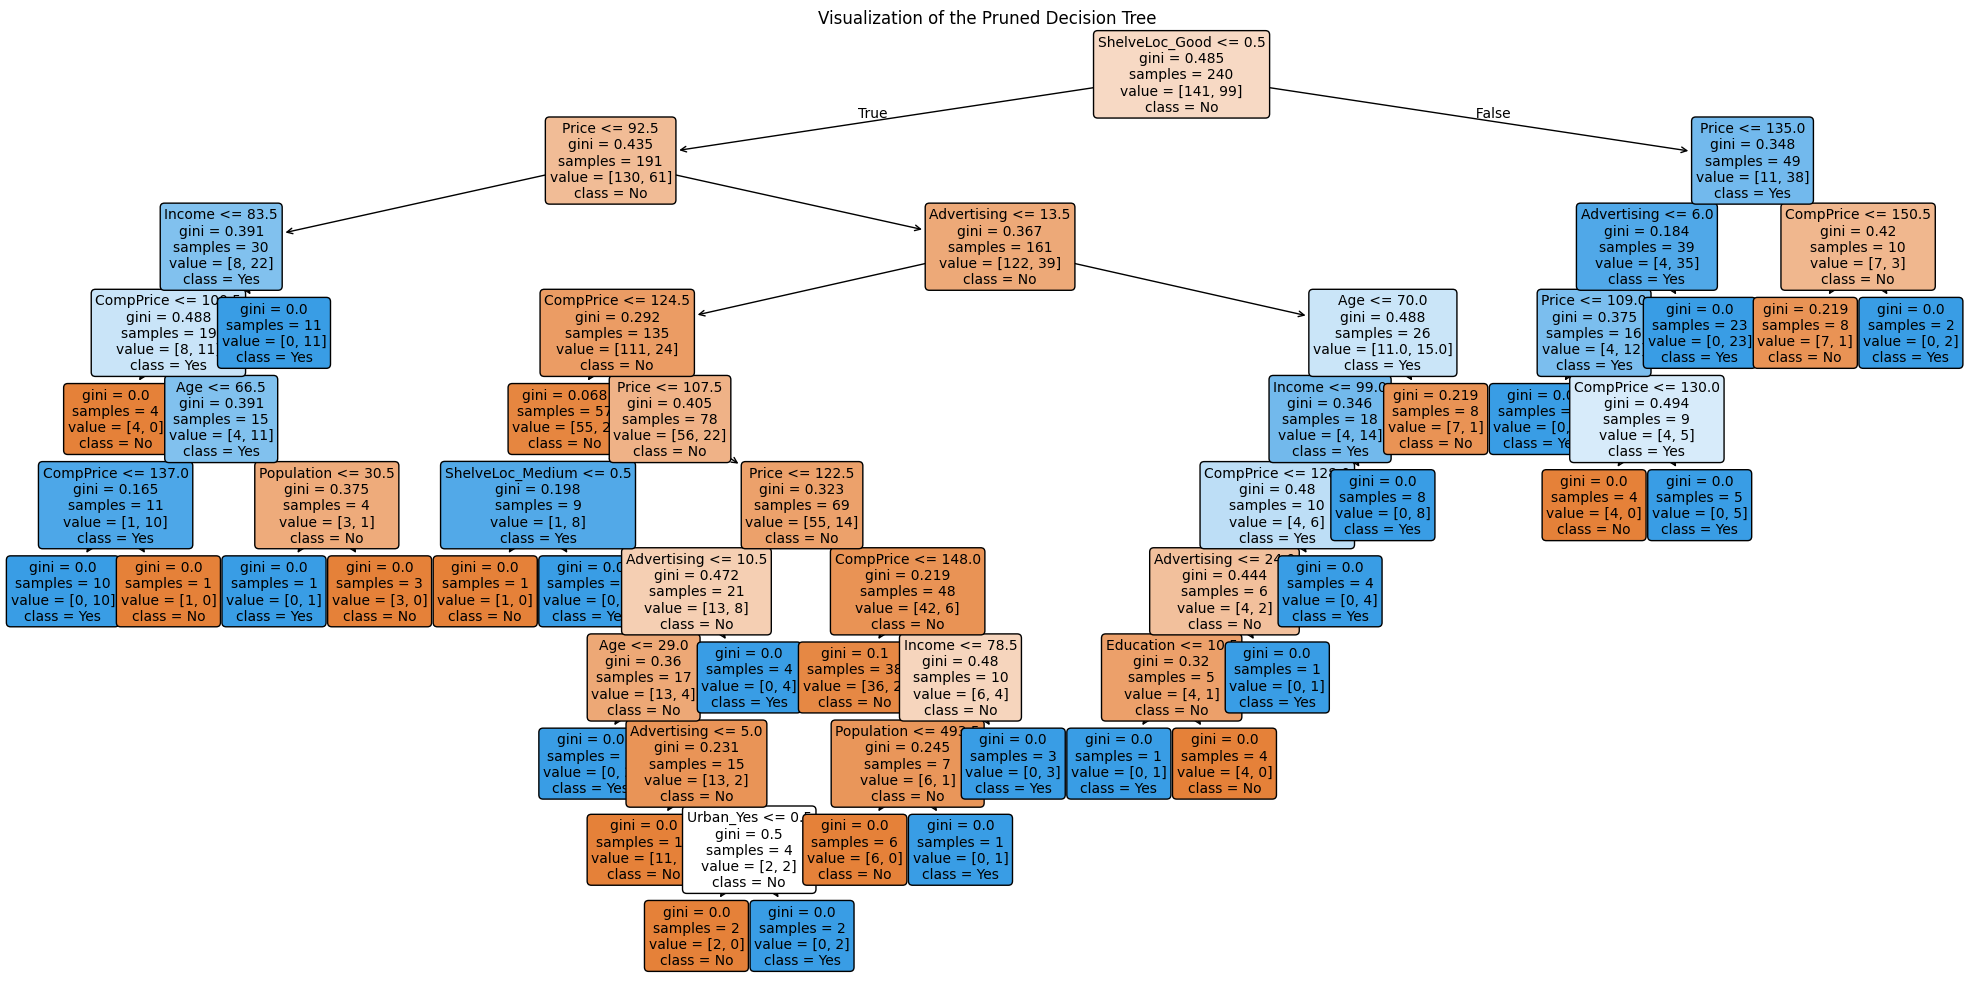


===== Test Set Evaluation of Best Model =====
Accuracy: 0.8125

Classification Report:
              precision    recall  f1-score   support

          No       0.81      0.90      0.85        48
         Yes       0.81      0.69      0.75        32

    accuracy                           0.81        80
   macro avg       0.81      0.79      0.80        80
weighted avg       0.81      0.81      0.81        80



In [25]:
#Select the best decision tree, taking into account both prediction accuracy
# and model size. Visualize the tree using the method plot_tree().
# Use the test set to evaluate the model.


# Select the best tree model considering both accuracy and complexity
print("\n===== Best Tree Model Selection =====")

# Calculate a combined score
# Higher weight means more emphasis on accuracy vs. model size
weight = 0.7  # 70% accuracy, 30% model size importance

# Normalize tree sizes to be between 0 and 1 (smaller is better)
max_size = max(unpruned_tree.get_n_leaves(), pruned_tree.get_n_leaves())
unpruned_size_score = 1 - (unpruned_tree.get_n_leaves() / max_size)
pruned_size_score = 1 - (pruned_tree.get_n_leaves() / max_size)

# Calculate combined scores
unpruned_combined_score = weight * unpruned_test_accuracy + (1 - weight) * unpruned_size_score
pruned_combined_score = weight * pruned_test_accuracy + (1 - weight) * pruned_size_score

print(f"Unpruned Tree - Test Accuracy: {unpruned_test_accuracy:.4f}, Size: {unpruned_tree.get_n_leaves()} leaves, Combined Score: {unpruned_combined_score:.4f}")
print(f"Pruned Tree - Test Accuracy: {pruned_test_accuracy:.4f}, Size: {pruned_tree.get_n_leaves()} leaves, Combined Score: {pruned_combined_score:.4f}")

# Select the best model based on combined score
if pruned_combined_score > unpruned_combined_score:
    best_model = pruned_tree
    best_model_name = "Pruned Decision Tree"
    print(f"\nBest model: {best_model_name} with combined score of {pruned_combined_score:.4f}")
else:
    best_model = unpruned_tree
    best_model_name = "Unpruned Decision Tree"
    print(f"\nBest model: {best_model_name} with combined score of {unpruned_combined_score:.4f}")

# Visualize the selected best tree
plt.figure(figsize=(20, 10))
plot_tree(best_model,
          feature_names=X_train.columns,
          class_names=best_model.classes_,
          filled=True,
          rounded=True,
          fontsize=10)
plt.title(f"Visualization of the {best_model_name}")
plt.tight_layout()
plt.show()

# Evaluate the best model on the test set
y_pred = best_model.predict(X_test)

# Generate detailed evaluation metrics
print("\n===== Test Set Evaluation of Best Model =====")
print(f"Accuracy: {accuracy_score(y_test, y_pred):.4f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred))




2. Use the [`DecisionTreeRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeRegressor.html) and [`RandomForestRegressor`](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html) models to predict the value of `medv` based on the other variables in the `boston.csv` dataset. Follow the steps from Task 1.

In [26]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeRegressor, plot_tree
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score

# Load the dataset
df = pd.read_csv('boston.csv')

# Display the first few rows to verify the data
print(df.head())

      crim    zn  indus  chas    nox     rm   age     dis  rad  tax  ptratio  \
0  0.00632  18.0   2.31     0  0.538  6.575  65.2  4.0900    1  296     15.3   
1  0.02731   0.0   7.07     0  0.469  6.421  78.9  4.9671    2  242     17.8   
2  0.02729   0.0   7.07     0  0.469  7.185  61.1  4.9671    2  242     17.8   
3  0.03237   0.0   2.18     0  0.458  6.998  45.8  6.0622    3  222     18.7   
4  0.06905   0.0   2.18     0  0.458  7.147  54.2  6.0622    3  222     18.7   

        b  lstat  medv  
0  396.90   4.98  24.0  
1  396.90   9.14  21.6  
2  392.83   4.03  34.7  
3  394.63   2.94  33.4  
4  396.90   5.33  36.2  


In [27]:
# Check for any missing values
print("\nMissing values per column:")
print(df.isnull().sum())


Missing values per column:
crim       0
zn         0
indus      0
chas       0
nox        0
rm         0
age        0
dis        0
rad        0
tax        0
ptratio    0
b          0
lstat      0
medv       0
dtype: int64


In [28]:
# Split features (X) and target (y)
X = df.drop('medv', axis=1)
y = df['medv']

# Divide data into training, validation, and test sets (60%, 20%, 20%)
X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=1)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=1)

print(f"\nData splits - Training: {X_train.shape[0]}, Validation: {X_val.shape[0]}, Test: {X_test.shape[0]}")


Data splits - Training: 303, Validation: 101, Test: 102


In [29]:
# Fit a DecisionTreeRegressor model
dt_regressor = DecisionTreeRegressor(random_state=42)
dt_regressor.fit(X_train, y_train)

# Evaluate the unpruned tree
y_train_pred_unpruned = dt_regressor.predict(X_train)
y_val_pred_unpruned = dt_regressor.predict(X_val)
y_test_pred_unpruned = dt_regressor.predict(X_test)

train_mse_unpruned = mean_squared_error(y_train, y_train_pred_unpruned)
val_mse_unpruned = mean_squared_error(y_val, y_val_pred_unpruned)
test_mse_unpruned = mean_squared_error(y_test, y_test_pred_unpruned)

train_r2_unpruned = r2_score(y_train, y_train_pred_unpruned)
val_r2_unpruned = r2_score(y_val, y_val_pred_unpruned)
test_r2_unpruned = r2_score(y_test, y_test_pred_unpruned)

print("\n===== Unpruned Decision Tree =====")
print(f"Tree Depth: {dt_regressor.get_depth()}, Leaves: {dt_regressor.get_n_leaves()}")
print(f"Training MSE: {train_mse_unpruned:.4f}, R²: {train_r2_unpruned:.4f}")
print(f"Validation MSE: {val_mse_unpruned:.4f}, R²: {val_r2_unpruned:.4f}")
print(f"Test MSE: {test_mse_unpruned:.4f}, R²: {test_r2_unpruned:.4f}")


===== Unpruned Decision Tree =====
Tree Depth: 20, Leaves: 286
Training MSE: 0.0000, R²: 1.0000
Validation MSE: 21.6181, R²: 0.7087
Test MSE: 18.7463, R²: 0.8103


In [30]:


# Apply pruning using cost complexity pruning
path = dt_regressor.cost_complexity_pruning_path(X_train, y_train)
ccp_alphas = path.ccp_alphas[:-1]  # Remove the largest value which would give a trivial tree

# Train models with different alphas and evaluate on validation set
dt_regressors = []
val_mse_scores = []

for ccp_alpha in ccp_alphas:
    dt = DecisionTreeRegressor(random_state=42, ccp_alpha=ccp_alpha)
    dt.fit(X_train, y_train)
    y_val_pred = dt.predict(X_val)
    val_mse = mean_squared_error(y_val, y_val_pred)
    val_mse_scores.append(val_mse)
    dt_regressors.append(dt)

# Find the best alpha (lowest MSE on validation set)
best_alpha_idx = np.argmin(val_mse_scores)
best_alpha = ccp_alphas[best_alpha_idx]
pruned_tree = dt_regressors[best_alpha_idx]

print("\n===== Pruning Results =====")
print(f"Best ccp_alpha: {best_alpha:.6f}")
print(f"Validation MSE with best alpha: {val_mse_scores[best_alpha_idx]:.4f}")


===== Pruning Results =====
Best ccp_alpha: 0.066464
Validation MSE with best alpha: 20.3824


In [31]:
# Evaluate the pruned tree
y_train_pred_pruned = pruned_tree.predict(X_train)
y_val_pred_pruned = pruned_tree.predict(X_val)
y_test_pred_pruned = pruned_tree.predict(X_test)

train_mse_pruned = mean_squared_error(y_train, y_train_pred_pruned)
val_mse_pruned = mean_squared_error(y_val, y_val_pred_pruned)
test_mse_pruned = mean_squared_error(y_test, y_test_pred_pruned)

train_r2_pruned = r2_score(y_train, y_train_pred_pruned)
val_r2_pruned = r2_score(y_val, y_val_pred_pruned)
test_r2_pruned = r2_score(y_test, y_test_pred_pruned)

print("\n===== Pruned Decision Tree =====")
print(f"Tree Depth: {pruned_tree.get_depth()}, Leaves: {pruned_tree.get_n_leaves()}")
print(f"Training MSE: {train_mse_pruned:.4f}, R²: {train_r2_pruned:.4f}")
print(f"Validation MSE: {val_mse_pruned:.4f}, R²: {val_r2_pruned:.4f}")
print(f"Test MSE: {test_mse_pruned:.4f}, R²: {test_r2_pruned:.4f}")

# Compare pruned and unpruned trees
print("\n===== Comparison of Tree Sizes =====")
print(f"Unpruned Tree - Depth: {dt_regressor.get_depth()}, Leaves: {dt_regressor.get_n_leaves()}")
print(f"Pruned Tree - Depth: {pruned_tree.get_depth()}, Leaves: {pruned_tree.get_n_leaves()}")
print(f"Reduction in Depth: {dt_regressor.get_depth() - pruned_tree.get_depth()} ({(1 - pruned_tree.get_depth()/dt_regressor.get_depth())*100:.1f}%)")
print(f"Reduction in Leaves: {dt_regressor.get_n_leaves() - pruned_tree.get_n_leaves()} ({(1 - pruned_tree.get_n_leaves()/dt_regressor.get_n_leaves())*100:.1f}%)")

print("\n===== Comparison of Prediction Quality =====")
print(f"Validation MSE - Unpruned: {val_mse_unpruned:.4f}, Pruned: {val_mse_pruned:.4f}")
print(f"Test MSE - Unpruned: {test_mse_unpruned:.4f}, Pruned: {test_mse_pruned:.4f}")
print(f"Test R² - Unpruned: {test_r2_unpruned:.4f}, Pruned: {test_r2_pruned:.4f}")


===== Pruned Decision Tree =====
Tree Depth: 10, Leaves: 41
Training MSE: 2.4932, R²: 0.9699
Validation MSE: 20.3824, R²: 0.7254
Test MSE: 16.8982, R²: 0.8290

===== Comparison of Tree Sizes =====
Unpruned Tree - Depth: 20, Leaves: 286
Pruned Tree - Depth: 10, Leaves: 41
Reduction in Depth: 10 (50.0%)
Reduction in Leaves: 245 (85.7%)

===== Comparison of Prediction Quality =====
Validation MSE - Unpruned: 21.6181, Pruned: 20.3824
Test MSE - Unpruned: 18.7463, Pruned: 16.8982
Test R² - Unpruned: 0.8103, Pruned: 0.8290


In [32]:


# Fit a RandomForestRegressor
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train, y_train)

# Evaluate the random forest
y_train_pred_rf = rf_regressor.predict(X_train)
y_val_pred_rf = rf_regressor.predict(X_val)
y_test_pred_rf = rf_regressor.predict(X_test)

train_mse_rf = mean_squared_error(y_train, y_train_pred_rf)
val_mse_rf = mean_squared_error(y_val, y_val_pred_rf)
test_mse_rf = mean_squared_error(y_test, y_test_pred_rf)

train_r2_rf = r2_score(y_train, y_train_pred_rf)
val_r2_rf = r2_score(y_val, y_val_pred_rf)
test_r2_rf = r2_score(y_test, y_test_pred_rf)

print("\n===== Random Forest Regressor =====")
print(f"Number of Trees: 100")
print(f"Training MSE: {train_mse_rf:.4f}, R²: {train_r2_rf:.4f}")
print(f"Validation MSE: {val_mse_rf:.4f}, R²: {val_r2_rf:.4f}")
print(f"Test MSE: {test_mse_rf:.4f}, R²: {test_r2_rf:.4f}")

# Compare all models
print("\n===== Model Comparison =====")
print("\nTraining MSE:")
print(f"Unpruned Decision Tree: {train_mse_unpruned:.4f}")
print(f"Pruned Decision Tree: {train_mse_pruned:.4f}")
print(f"Random Forest: {train_mse_rf:.4f}")

print("\nTest MSE:")
print(f"Unpruned Decision Tree: {test_mse_unpruned:.4f}")
print(f"Pruned Decision Tree: {test_mse_pruned:.4f}")
print(f"Random Forest: {test_mse_rf:.4f}")

print("\nTest R²:")
print(f"Unpruned Decision Tree: {test_r2_unpruned:.4f}")
print(f"Pruned Decision Tree: {test_r2_pruned:.4f}")
print(f"Random Forest: {test_r2_rf:.4f}")

# Overfitting analysis
print("\nOverfitting (Train-Test MSE Difference):")
print(f"Unpruned Decision Tree: {train_mse_unpruned - test_mse_unpruned:.4f}")
print(f"Pruned Decision Tree: {train_mse_pruned - test_mse_pruned:.4f}")
print(f"Random Forest: {train_mse_rf - test_mse_rf:.4f}")


===== Random Forest Regressor =====
Number of Trees: 100
Training MSE: 1.4098, R²: 0.9830
Validation MSE: 13.8019, R²: 0.8140
Test MSE: 11.3301, R²: 0.8854

===== Model Comparison =====

Training MSE:
Unpruned Decision Tree: 0.0000
Pruned Decision Tree: 2.4932
Random Forest: 1.4098

Test MSE:
Unpruned Decision Tree: 18.7463
Pruned Decision Tree: 16.8982
Random Forest: 11.3301

Test R²:
Unpruned Decision Tree: 0.8103
Pruned Decision Tree: 0.8290
Random Forest: 0.8854

Overfitting (Train-Test MSE Difference):
Unpruned Decision Tree: -18.7463
Pruned Decision Tree: -14.4050
Random Forest: -9.9203



===== Best Tree Model Selection =====
Unpruned Tree - Test MSE: 18.7463, Size: 286 leaves, Combined Score: 0.0000
Pruned Tree - Test MSE: 16.8982, Size: 41 leaves, Combined Score: 0.3145

Best model: Pruned Decision Tree with combined score of 0.3145


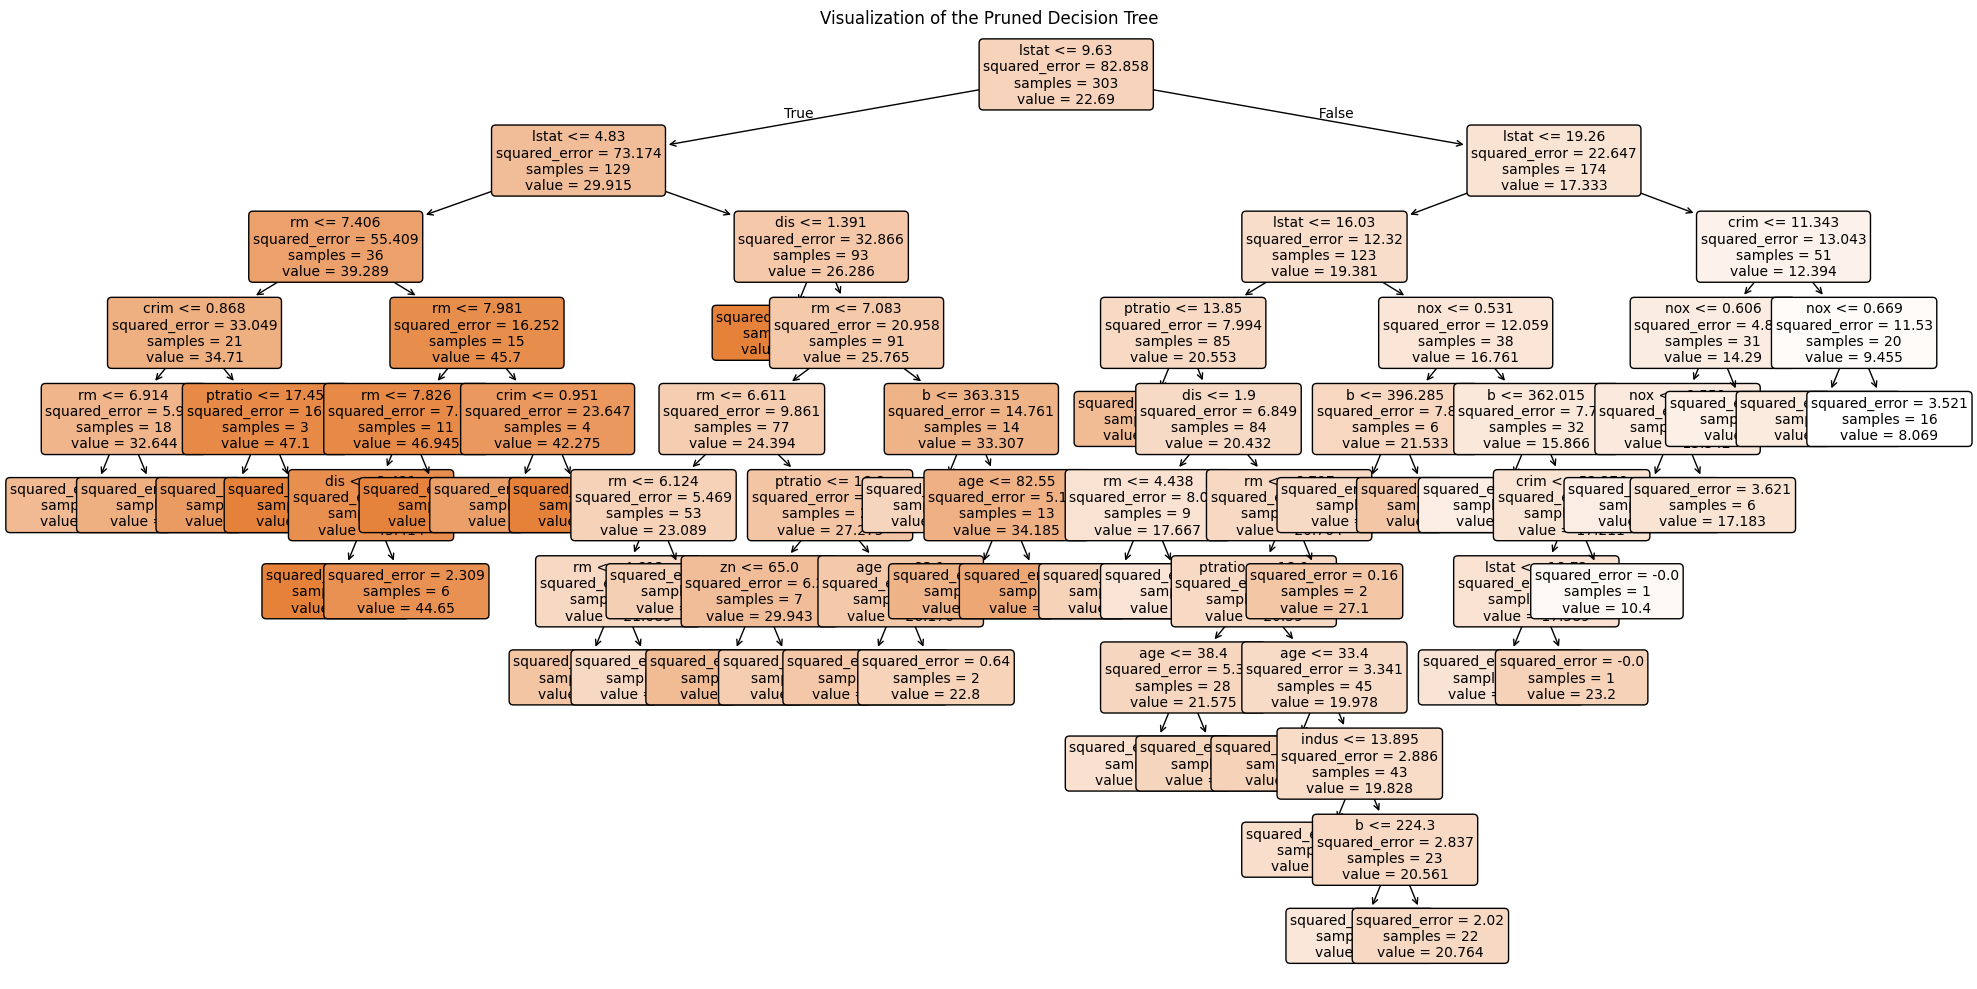

In [33]:
# Select the best decision tree model (balancing accuracy and simplicity)
# For regression, lower MSE is better
weight = 0.7  # Weight for accuracy vs model size (0.7 means 70% importance on accuracy)

# Normalize tree sizes to be between 0 and 1 (smaller is better)
max_size = max(dt_regressor.get_n_leaves(), best_tree.get_n_leaves())
unpruned_size_score = 1 - (dt_regressor.get_n_leaves() / max_size)
pruned_size_score = 1 - (best_tree.get_n_leaves() / max_size)

# For MSE, lower is better, so invert for scoring
max_mse = max(test_mse_unpruned, test_mse_pruned)
unpruned_mse_score = 1 - (test_mse_unpruned / max_mse)
pruned_mse_score = 1 - (test_mse_pruned / max_mse)

# Calculate combined scores
unpruned_combined_score = weight * unpruned_mse_score + (1 - weight) * unpruned_size_score
pruned_combined_score = weight * pruned_mse_score + (1 - weight) * pruned_size_score

print("\n===== Best Tree Model Selection =====")
print(f"Unpruned Tree - Test MSE: {test_mse_unpruned:.4f}, Size: {dt_regressor.get_n_leaves()} leaves, Combined Score: {unpruned_combined_score:.4f}")
print(f"Pruned Tree - Test MSE: {test_mse_pruned:.4f}, Size: {pruned_tree.get_n_leaves()} leaves, Combined Score: {pruned_combined_score:.4f}")

# Select the best model based on combined score
if pruned_combined_score > unpruned_combined_score:
    best_model = pruned_tree
    best_model_name = "Pruned Decision Tree"
    print(f"\nBest model: {best_model_name} with combined score of {pruned_combined_score:.4f}")
else:
    best_model = dt_regressor
    best_model_name = "Unpruned Decision Tree"
    print(f"\nBest model: {unpruned_combined_score:.4f}")

# Visualize the selected best tree
plt.figure(figsize=(20, 10))
plot_tree(best_model,
          feature_names=X_train.columns,
          filled=True,
          rounded=True,
          fontsize=10)
plt.title(f"Visualization of the {best_model_name}")
plt.tight_layout()
plt.show()